# Researcher and Quant Lab Overview

This lab demonstrates key concepts supporting bespoke analysis and research leveraging widely known tools of python, notebooks, and SQL with Google Cloud's BigQuery and Compute instances.  This demonstration also leverages BigQuery's ability to share data from key source providers like LSEG, Bloomberg, CME Group, and others as needed by data consumers.


---

Key insights articulated:
1. Bespoke analysis against financial information hosted by LSEG in BQ(Refinitiv)
1. Demonstration of BigQuery serverless approach to automatically scale against queries measured in Petabyte of underlying data.
1. No queuing of Researcher's requests based upon size or complexity of analysis needs.
1. GenAI code integration to enhance Researcher's abilities
1. GenAI tooling already embedded for automation of research reports

# Establish Content Understanding
Equity tick data supplied by LSEG

In [69]:
import pandas as pd
import matplotlib.pyplot as plt

sql = '''SELECT * FROM (
    WITH AllTrades AS(
      SELECT Date_Time,RIC,Price,Volume
      FROM `dbd-sdlc-prod.LSE_NORMALISED.LSE_NORMALISED`
      WHERE Price IS NOT NULL
      -- Specific Date/Time range:
      AND (Date_Time BETWEEN "2023-01-01 12:00:00.000000" AND "2023-03-31 12:59:59.999999")
      AND Type = "Trade"
      AND VOLUME > 0
      AND PRICE > 0
      # All trades reported as "On Book" & "Regular Trades"
      # This is according to the FIX specs, most European trading venues adhere to this
      AND RIGHT(REGEXP_EXTRACT(Qualifiers, r";(.*)\[MMT_CLASS\]"),14) LIKE "12%"
    )
    SELECT RIC, ROUND(SAFE_DIVIDE(SUM(Volume*Price),SUM(Volume)),3) AS VWAP,SUM(Volume) AS TotalVolume,COUNT(RIC) AS NumTrades, extract(DATE FROM Date_Time) AS Date
    FROM AllTrades
    WHERE RIC IN ('ULVR.L','VOD.L')
    GROUP BY RIC, Date
    ORDER BY RIC
)'''

df = pd.read_gbq(sql)
df['Date'] = pd.to_datetime(df['Date'])
df=df.sort_values('Date')
#df = df.set_index('Date')
df.head()


,RIC,VWAP,TotalVolume,NumTrades,Date
33,ULVR.L,4178.656000000,1552278.000000000,10274,2023-01-03
94,VOD.L,85.852000000,32540692.000000000,10979,2023-01-03
36,ULVR.L,4219.521000000,1198241.000000000,8713,2023-01-04
113,VOD.L,87.294000000,34642755.000000000,11745,2023-01-04
22,ULVR.L,4207.306000000,740899.000000000,5189,2023-01-05


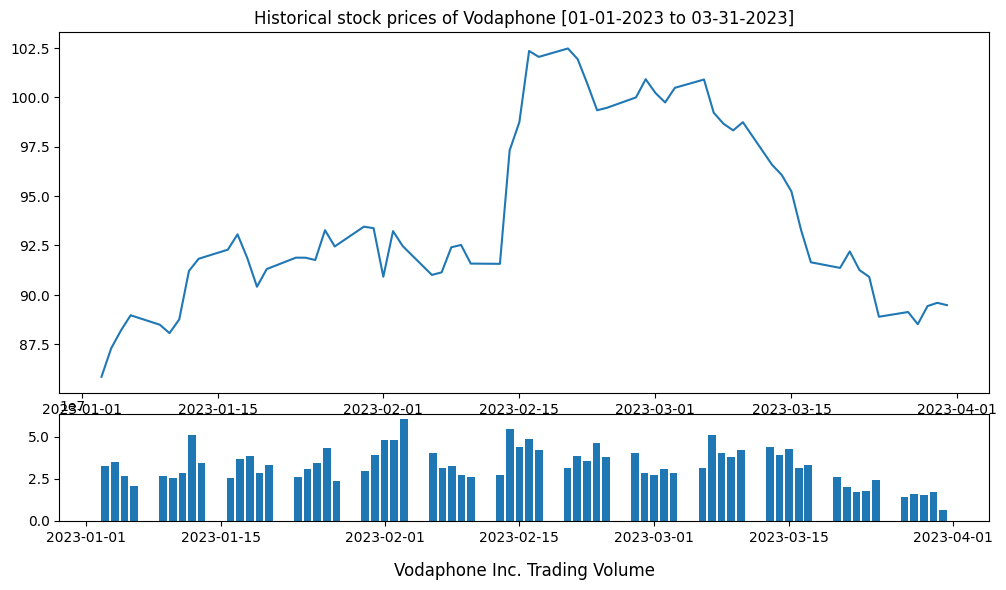

In [70]:
df = df[df['RIC']=='VOD.L']
top_plt = plt.subplot2grid((5,4), (0, 0), rowspan=3, colspan=4)
top_plt.plot(df['Date'], df["VWAP"])
plt.title('Historical stock prices of Vodaphone [01-01-2023 to 03-31-2023]')

bottom_plt = plt.subplot2grid((5,4), (3,0), rowspan=1, colspan=4)
bottom_plt.bar(df['Date'], df['TotalVolume'])
plt.title('Vodaphone Inc. Trading Volume', y=-0.60)
plt.gcf().set_size_inches(12,8)

# Scale Calculations Demonstration
- Demonstate the scalablity of analysis removing the complexity of capacity planning, historical data repositories, and rigid analysis patterns.  

In [38]:
!curl https://bootstrap.pypa.io/get-pip.py -o get-pip.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0^C


In [78]:
# Import
import os

################################# CHANGE ME ###############################
#### Change this to the name of your Google Cloud Project - used for billing!
os.environ["GCLOUD_PROJECT"] = "duet-1"


######## DO NOT CHANGE BELOW THIS LINE #######################
# Helper utils to make pretty stats
from IPython.core.display import  HTML
import humanize
import datetime

def nicetime(millis):
  return humanize.naturaldelta(datetime.timedelta(milliseconds=millis.item()))

def print_query_stats(query):
  return HTML( f"<h2>Query completed in <u>{nicetime(query['execution_time_ms'][0])}</u> (walltime) with a total scaled compute time of <u>{nicetime(query['total_slot_ms'][0])}</u> , {query['speedup'][0]:.0f}x speedup </h2> \
  <h2>Total Rows Scanned: {humanize.intword(query['rows_read'][0])} <h2> \
   <h2>Total Bytes Processed:  {humanize.naturalsize(query['total_bytes_processed'][0])} </h2>" )

In [40]:
# Sign in to Google
from google.colab import auth
auth.authenticate_user()

## 1) High/Low Bars for LSE L2 - 1 day / Hourly



In [41]:
%%bigquery
SELECT
  RIC,
  TIMESTAMP_TRUNC(date_time, HOUR) AS time_group,
  MAX(L2_BidPrice) AS max_bid,
  MIN(L2_BidPrice) AS min_bid
FROM
  #LSE_NORMALISEDLL2.LSE_NORMALISEDLL2
  `dbd-sdlc-prod.LSE_NORMALISEDLL2.LSE_NORMALISEDLL2`
WHERE
  #Date_Time BETWEEN "2019-07-01 00:00:00" AND "2019-07-01 23:59:59"
  Date_Time BETWEEN "2019-07-01 00:00:00" AND "2019-07-01 23:59:59"
  and RAND() < 2  # Removes BQ Caching!
GROUP BY
  RIC,
  time_group
LIMIT 100

Query is running:   0%|          |

Downloading:   0%|          |

,RIC,time_group,max_bid,min_bid
0,STAN.L,2019-07-01 15:00:00+00:00,750.400000000,711.400000000
1,ULVR.L,2019-07-01 14:00:00+00:00,4927.500000000,4915.000000000
2,VOD.L,2019-07-01 06:00:00+00:00,133.680000000,125.000000000
3,VOD.L,2019-07-01 07:00:00+00:00,133.680000000,129.140000000
4,STAN.L,2019-07-01 08:00:00+00:00,717.400000000,714.600000000
5,VOD.L,2019-07-01 13:00:00+00:00,129.100000000,126.580000000
6,STAN.L,2019-07-01 16:00:00+00:00,712.600000000,679.000000000
7,ULVR.L,2019-07-01 09:00:00+00:00,4912.500000000,4904.500000000
8,STAN.L,2019-07-01 11:00:00+00:00,717.200000000,713.600000000
9,VOD.L,2019-07-01 11:00:00+00:00,132.000000000,130.060000000


In [42]:
%%bigquery execstats2
SELECT
  total_slot_ms,
  total_bytes_processed,
  TIMESTAMP_DIFF(end_time, start_time, MILLISECOND) AS execution_time_ms,
  (total_slot_ms / TIMESTAMP_DIFF(end_time, start_time, MILLISECOND) ) AS speedup,
  rowz.records_read	as rows_read
FROM
  `region-us`.INFORMATION_SCHEMA.JOBS_BY_USER,
  UNNEST(job_stages) as rowz
WHERE
  creation_time >= TIMESTAMP(CURRENT_DATE())
  AND state = "DONE"
  AND query NOT LIKE "%INFORMATION_SCHEMA%"
  AND rowz.name = "S00: Input"

ORDER BY
  creation_time DESC
LIMIT
  1

Query is running:   0%|          |

Downloading:   0%|          |

In [79]:
print_query_stats(execstats2)

## 2) High/Low Bars for LSE L2 - 1 month / Minutes (10 years ago)
- Demonstrate using older data from tick repository

In [80]:
%%bigquery
SELECT
  RIC,
  TIMESTAMP_TRUNC(date_time, MINUTE) AS time_group,
  MAX(L2_BidPrice) AS max_bid,
  MIN(L2_BidPrice) AS min_bid
FROM
  `dbd-sdlc-prod.LSE_NORMALISEDLL2.LSE_NORMALISEDLL2`
WHERE
  Date_Time BETWEEN "2010-07-01 00:00:00" AND "2010-07-31 23:59:59"
  and RAND() < 2
GROUP BY
  RIC,
  time_group
LIMIT 100

Query is running:   0%|          |

Downloading:   0%|          |

,RIC,time_group,max_bid,min_bid
0,DOM.LV,2010-07-20 12:06:00+00:00,None,None
1,DJMC.L,2010-07-20 07:22:00+00:00,2736.000000000,2734.000000000
2,DMGOa.LV,2010-07-20 09:40:00+00:00,None,None
3,DLAR.LV,2010-07-20 12:05:00+00:00,None,None
4,DL2P.LV,2010-07-20 10:10:00+00:00,None,None
...,...,...,...,...
95,DMGOa.L,2010-07-20 13:42:00+00:00,450.800000000,450.700000000
96,DOPL.L,2010-07-20 15:39:00+00:00,5.600000000,5.600000000
97,DOPL.L,2010-07-20 14:07:00+00:00,5.500000000,5.500000000
98,DLN.L,2010-07-20 07:11:00+00:00,1310.000000000,1310.000000000


In [81]:
%%bigquery execstats3
SELECT
  total_slot_ms,
  total_bytes_processed,
  TIMESTAMP_DIFF(end_time, start_time, MILLISECOND) AS execution_time_ms,
  (total_slot_ms / TIMESTAMP_DIFF(end_time, start_time, MILLISECOND) ) AS speedup,
  rowz.records_read	as rows_read
FROM
  `region-us`.INFORMATION_SCHEMA.JOBS_BY_USER,
  UNNEST(job_stages) as rowz
WHERE
  creation_time >= TIMESTAMP(CURRENT_DATE())
  AND state = "DONE"
  AND query NOT LIKE "%INFORMATION_SCHEMA%"
  AND rowz.name = "S00: Input"
ORDER BY
  creation_time DESC
LIMIT
  1

Query is running:   0%|          |

Downloading:   0%|          |

In [82]:
print_query_stats(execstats3)

## 3) High/Low Bars for LSE L2 - 6 months / Daily
- Demonstrate common pattern for recent historical data with highest time aggregations


In [83]:
%%bigquery
SELECT
  RIC,
  TIMESTAMP_TRUNC(date_time, DAY) AS time_group,
  MAX(L2_BidPrice) AS max_bid,
  MIN(L2_BidPrice) AS min_bid
FROM
  `dbd-sdlc-prod.LSE_NORMALISEDLL2.LSE_NORMALISEDLL2`
WHERE
  Date_Time BETWEEN "2019-07-01 00:00:00" AND "2019-12-31 23:59:59"
    AND RAND() < 2  # Removes BQ Caching!

GROUP BY
  RIC,
  time_group
LIMIT 100

Query is running:   0%|          |

Downloading:   0%|          |

,RIC,time_group,max_bid,min_bid
0,CNA.L,2019-12-18 00:00:00+00:00,94.520000000,60.000000000
1,PMO.L,2019-10-21 00:00:00+00:00,86.520000000,59.500000000
2,EEIP.L,2019-12-18 00:00:00+00:00,None,None
3,MCLSM.L,2019-12-18 00:00:00+00:00,38.900000000,36.100000000
4,EMCP.L,2019-10-01 00:00:00+00:00,84.190000000,82.610000000
...,...,...,...,...
95,PLP.L,2019-08-16 00:00:00+00:00,393.400000000,341.400000000
96,XBCU.L,2019-08-01 00:00:00+00:00,22.480000000,21.530000000
97,EUAG.L,2019-10-17 00:00:00+00:00,63.830000000,63.600000000
98,KUW8.L,2019-10-17 00:00:00+00:00,None,None


In [84]:
%%bigquery execstats4
SELECT
  total_slot_ms,
  total_bytes_processed,
  TIMESTAMP_DIFF(end_time, start_time, MILLISECOND) AS execution_time_ms,
  (total_slot_ms / TIMESTAMP_DIFF(end_time, start_time, MILLISECOND) ) AS speedup,
  rowz.records_read	as rows_read
FROM
  `region-us`.INFORMATION_SCHEMA.JOBS_BY_USER,
  UNNEST(job_stages) as rowz
WHERE
  creation_time >= TIMESTAMP(CURRENT_DATE())
  AND state = "DONE"
  AND query NOT LIKE "%INFORMATION_SCHEMA%"
  AND rowz.name = "S00: Input"
ORDER BY
  creation_time DESC
LIMIT
  1

Query is running:   0%|          |

Downloading:   0%|          |

In [86]:
print_query_stats(execstats4)

## 4) High/Low Bars for LSE L2 - 5 years / Hourly
- Demonstrate large historical scan with many lots of data slices.

In [87]:
%%bigquery
SELECT
  RIC,
  TIMESTAMP_TRUNC(date_time, HOUR) AS time_group,
  MAX(L2_BidPrice) AS max_bid,
  MIN(L2_BidPrice) AS min_bid
FROM
  `dbd-sdlc-prod.LSE_NORMALISEDLL2.LSE_NORMALISEDLL2`
WHERE
  Date_Time BETWEEN "2015-01-01 00:00:00" AND "2020-01-01 00:00:00"
    AND RAND() < 2  # Removes BQ Caching!

GROUP BY
  RIC,
  time_group
LIMIT 100

Query is running:   0%|          |

Downloading:   0%|          |

,RIC,time_group,max_bid,min_bid
0,BTW_pa.L,2017-06-19 02:00:00+00:00,None,None
1,BLPU.L,2017-06-19 16:00:00+00:00,None,None
2,BIFF.L,2017-06-19 02:00:00+00:00,None,None
3,POLYP.L,2017-06-19 08:00:00+00:00,905.500000000,896.500000000
4,BARV.L,2017-06-19 02:00:00+00:00,None,None
...,...,...,...,...
95,VTBR000140L7.LLd,2017-06-19 13:00:00+00:00,None,None
96,VTBR000220T7.LLd,2017-06-19 11:00:00+00:00,None,None
97,VTBR000340F8.LLd,2017-06-19 08:00:00+00:00,None,None
98,SITB.L,2017-05-10 13:00:00+00:00,130.570000000,130.340000000


In [88]:
%%bigquery execstats5
SELECT
  total_slot_ms,
  total_bytes_processed,
  TIMESTAMP_DIFF(end_time, start_time, MILLISECOND) AS execution_time_ms,
  (total_slot_ms / TIMESTAMP_DIFF(end_time, start_time, MILLISECOND) ) AS speedup,
  rowz.records_read	as rows_read
FROM
  `region-us`.INFORMATION_SCHEMA.JOBS_BY_USER,
  UNNEST(job_stages) as rowz
WHERE
  creation_time >= TIMESTAMP(CURRENT_DATE())
  AND state = "DONE"
  AND query NOT LIKE "%INFORMATION_SCHEMA%"
  AND rowz.name = "S00: Input"
ORDER BY
  creation_time DESC
LIMIT
  1

Query is running:   0%|          |

Downloading:   0%|          |

In [89]:
print_query_stats(execstats5)

## Summary of Performance Scale

In [90]:
%%bigquery query_stats
SELECT
  total_slot_ms,
  total_bytes_processed,
  TIMESTAMP_DIFF(end_time, start_time, MILLISECOND) AS execution_time_ms,
  (total_slot_ms / TIMESTAMP_DIFF(end_time, start_time, MILLISECOND) ) AS speedup,
  rowz.records_read	as rows_read
FROM
  `region-us`.INFORMATION_SCHEMA.JOBS_BY_USER,
  UNNEST(job_stages) as rowz
WHERE
  creation_time >= TIMESTAMP(CURRENT_DATE())
  AND state = "DONE"
  AND query NOT LIKE "%INFORMATION_SCHEMA%"
  AND rowz.name = "S00: Input"
ORDER BY
  creation_time DESC
LIMIT
  4

Query is running:   0%|          |

Downloading:   0%|          |

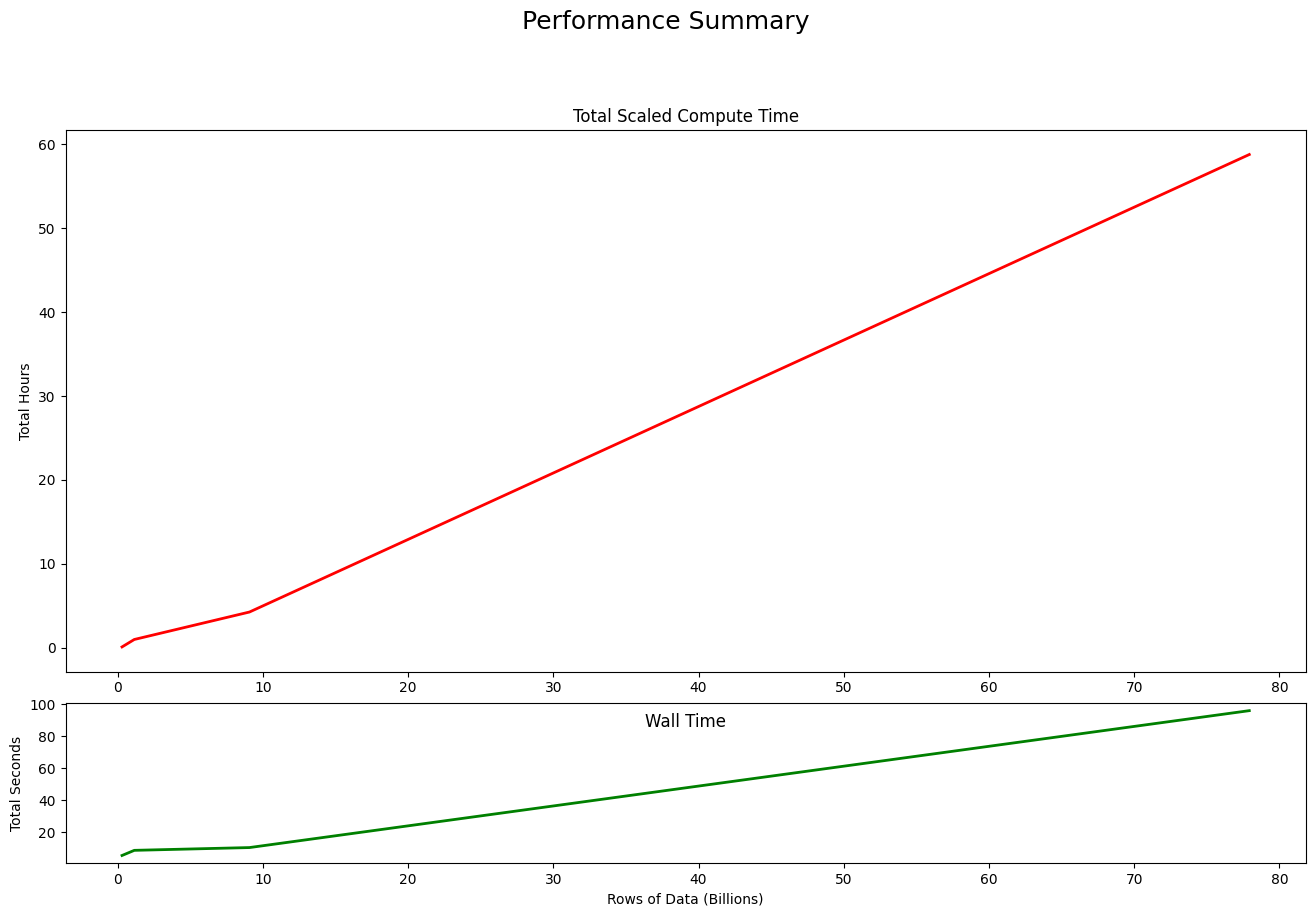

In [160]:
top_plt = plt.subplot2grid((5,4), (0, 0), rowspan=3, colspan=4)
x = query_stats['rows_read']/1000000000
y = query_stats['total_slot_ms'] / 1000  / 3600
y2 = query_stats['execution_time_ms']/ 1000

top_plt.plot(x, y, linewidth=2, color='red')
plt.title('Total Scaled Compute Time')
plt.ylabel("Total Hours")


bottom_plt = plt.subplot2grid((5,4), (3,0), rowspan=1, colspan=4)
bottom_plt.plot(x, y2, linewidth=2, color='green')
plt.title('Wall Time', y=0.8)
plt.ylabel("Total Seconds")
plt.xlabel("Rows of Data (Billions)")

plt.suptitle('Performance Summary', fontsize=18)
#plt.tight_layout()

plt.gcf().set_size_inches(16,12)


# GenAI Coding Help and Embeddding into Analysis Output

In [ ]:
# Ask for python script to download data from yahoo finance: download data from yahoo finance
# Calcuate CAGR: cagr
# Calcuate normalized return of a dataframe: normalized return
# Filter the data by a specific: filter df by a symbol

#this is very alpha...

In [ ]:
# prompt: sort dataframe by date

df.sort_values('date', inplace=True)

In [ ]:
# prompt: filter df by a symbol

df[df['Symbol'] == 'AAPL']

In [ ]:
# prompt: filter df by a symbol

df[df['RIC']=='VOD.L']

## 1) Data Setup
- Create a table of Day over Day Information for VOD & ULVR

In [59]:
%%bigquery structuredReport
CREATE OR REPLACE VIEW `lseg_testing.LSE_PIVOTED_BY_RIC` AS
SELECT * FROM (
    WITH AllTrades AS(
      SELECT Date_Time,RIC,Price,Volume
      #FROM `dbd-sdlc-prod.LSE_NORMALISED.LSE_NORMALISED`
      FROM LSE_NORMALISED.LSE_NORMALISED
      WHERE Price IS NOT NULL
      -- Specific Date/Time range:2020-07-23
      AND (Date_Time BETWEEN "2020-07-23 12:00:00.000000" AND "2023-07-24 12:59:59.999999")
      AND Type = "Trade"
      AND VOLUME > 0
      AND PRICE > 0
      # All trades reported as "On Book" & "Regular Trades"
      # This is according to the FIX specs, most European trading venues adhere to this
      AND RIGHT(REGEXP_EXTRACT(Qualifiers, r";(.*)\[MMT_CLASS\]"),14) LIKE "12%"
    )
    SELECT RIC, ROUND(SAFE_DIVIDE(SUM(Volume*Price),SUM(Volume)),3) AS VWAP,SUM(Volume) AS TotalVolume,COUNT(RIC) AS NumTrades, extract(DATE FROM Date_Time) AS vwap_date
    FROM AllTrades
    WHERE RIC IN ('ULVR.L','VOD.L')
    GROUP BY RIC, vwap_date
    ORDER BY RIC
)
PIVOT (
  AVG (VWAP) AS VWAP,
  SUM (TotalVolume) AS TotalVolume,
  SUM(NumTrades) AS NumTrades
  FOR vwap_date in ('2023-05-17', '2023-05-16'))

Query is running:   0%|          |

In [60]:
%%bigquery structuredReport
SELECT * FROM lseg_testing.LSE_PIVOTED_BY_RIC


Query is running:   0%|          |

Downloading:   0%|          |

In [61]:
structuredReport.head()

,RIC,VWAP_2023_05_17,TotalVolume_2023_05_17,NumTrades_2023_05_17,VWAP_2023_05_16,TotalVolume_2023_05_16,NumTrades_2023_05_16
0,VOD.L,83.356000000,36979037.000000000,11346,83.807000000,123639894.000000000,31061
1,ULVR.L,4337.955000000,984748.000000000,6689,4342.105000000,940027.000000000,6027


## 2) Establish LLM Connection and Settings

In [62]:
%%bigquery
-- CREATE THE CONNECTION TO THE LLM
CREATE OR REPLACE MODEL lseg_testing.llm_model
  REMOTE WITH CONNECTION `us.call-palm2`
  OPTIONS (remote_service_type = 'CLOUD_AI_LARGE_LANGUAGE_MODEL_V1');



Query is running:   0%|          |

""


## 3) Create Summary

In [63]:
%%bigquery GenAISummary
-- CREATE SUMMARY COMPARING VWAP, VOLUME AND NUMBER TRADES OVER TIME PER RIC
  SELECT * FROM
  ML.GENERATE_TEXT(
    MODEL `lseg_testing.llm_model`,
    (
  SELECT
        CONCAT('From the following trading information, make an executive summary comparing vwap, volume and number of trades over 2 days. Always mention the company legal name based on the RIC:',
        RIC,' vwap day one:', VWAP_2023_05_16, ' vwap day 2', VWAP_2023_05_17, ' total trades day one', NumTrades_2023_05_16, ' trades day 2:',NumTrades_2023_05_17, 'total volume day one: ',TotalVolume_2023_05_16,' total volume day 2:',TotalVolume_2023_05_17 )
        AS prompt from `lseg_testing.LSE_PIVOTED_BY_RIC`

        ),
    STRUCT(
      0.2 AS temperature,
      800 AS max_output_tokens,
      TRUE AS flatten_json_output));

Query is running:   0%|          |

Downloading:   0%|          |

In [64]:
HTML(GenAISummary['ml_generate_text_llm_result'][0])

In [65]:
HTML(GenAISummary['ml_generate_text_llm_result'][1])

In [66]:
# Filtering and controls also supplied
HTML(GenAISummary['ml_generate_text_rai_result'][0])